In [ ]:
Baseline RNN ptbdb

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, GRU, Flatten

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [4]:
df_1 = pd.read_csv("../input/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("../input/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])


Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [40]:
def get_model():
    nclass = 1
    inp = Input(shape=(187, 1))
    img_1 = GRU(256, return_sequences=True)(inp)
    img_1 = Flatten()(img_1)
    
    outputs = Dense(nclass, activation='sigmoid')(img_1)
    
    model = models.Model(inputs=inp, outputs=outputs)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    
    return model


In [41]:
model = get_model()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 187, 1)]          0         
_________________________________________________________________
gru_13 (GRU)                 (None, 187, 256)          198912    
_________________________________________________________________
flatten_12 (Flatten)         (None, 47872)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 47873     
Total params: 246,785
Trainable params: 246,785
Non-trainable params: 0
_________________________________________________________________


In [28]:
file_path = "baseline_rnn_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(X, Y, batch_size=64, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/1000
164/164 [==============================] - 74s 449ms/step - loss: 0.3601 - acc: 0.8358 - val_loss: 0.3657 - val_acc: 0.8309

Epoch 00001: val_acc improved from -inf to 0.83090, saving model to baseline_rnn_ptbdb.h5
Epoch 2/1000
164/164 [==============================] - 73s 445ms/step - loss: 0.3224 - acc: 0.8575 - val_loss: 0.3115 - val_acc: 0.8592

Epoch 00002: val_acc improved from 0.83090 to 0.85923, saving model to baseline_rnn_ptbdb.h5
Epoch 3/1000
164/164 [==============================] - 76s 464ms/step - loss: 0.2943 - acc: 0.8743 - val_loss: 0.2941 - val_acc: 0.8824

Epoch 00003: val_acc improved from 0.85923 to 0.88240, saving model to baseline_rnn_ptbdb.h5
Epoch 4/1000
164/164 [==============================] - 78s 474ms/step - loss: 0.2684 - acc: 0.8849 - val_loss: 0.2629 - val_acc: 0.8764

Epoch 00004: val_acc did not improve from 0.88240
Epoch 5/1000
164/164 [==============================] - 75s 459ms/step - loss: 0.2300 - acc: 0.9008 - val_loss: 0.2511 - v

In [29]:
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.9885985748218526 
Test accuracy score : 0.9835108210237032 


In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, pred_test)
auc_keras = auc(fpr_keras, tpr_keras)
print("AUROC score : %s "% auc_keras)

AUROC score : 0.9783174891415439 


In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(Y_test, pred_test)
auroc = auc(fpr, tpr)
print("AUROC score : %s "% auroc)

AUROC score : 0.9783174891415439 


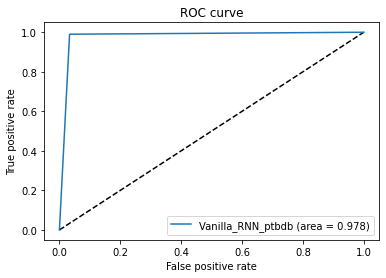

In [32]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Vanilla_RNN_ptbdb (area = {:.3f})'.format(auroc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('AUROC_RNN_vanilla_ptbdb.png')
plt.show()

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(Y_test, pred_test)
# calculate the precision-recall auc
auprc = auc(recall, precision)
print("AUPRC score : %s "% auprc)

AUPRC score : 0.9922075907019395 


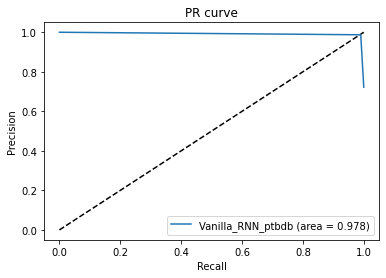

In [34]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall, precision, label='Vanilla_RNN_ptbdb (area = {:.3f})'.format(auroc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc='best')
plt.savefig('AUPRC_RNN_vanilla_ptbdb.png')
plt.show()